In [1]:
import numpy as np
import os
import keras
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

from UnetModel import *

%matplotlib inline


#Load pre-trained model
UnetModel.img_rows = 224
UnetModel.img_cols = 224

UnetModel.batch_size = 6
UnetModel.batch_norm = False
UnetModel.layer_norm = True

input_shape = (UnetModel.img_rows,UnetModel.img_cols,3)
#base_model=ResNet50(weights='imagenet',include_top=False, input_shape = input_shape) #imports the resnet model and discards the last 1000 neuron layer.
base_model=ResNet50(weights='imagenet',include_top=False, input_shape = input_shape) #imports the resnet model and discards the last 1000 neuron layer.


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


C:\Users\li_ni\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [2]:
for layer in base_model.layers:
    layer.trainable = True
    
x = base_model.output

bottom  = double_block(x, 1024, prefix='bottom')

# 14 x 14 block5
left_block5 = base_model.get_layer('activation_40').output
right_conv5 = up_sampling_block(bottom, left_block5, 512, 'right_conv5')

# 28 x 28 block4
left_block4 = base_model.get_layer('activation_22').output
right_conv4 = up_sampling_block(right_conv5, left_block4, 256, 'right_conv4')

# 56 x 56 block3
left_block3 = base_model.get_layer('activation_10').output
right_conv3 = up_sampling_block(right_conv4, left_block3, 128, 'right_conv3')

# 112 x 112 block2
left_block2 = base_model.get_layer('activation_1').output
right_conv2 = up_sampling_block(right_conv3, left_block2, 64, 'right_conv2')

#Resnet doesn't have 224 x 224 layer conv, use first conv layer in VGG16 instead
vgg = VGG16(input_shape=input_shape, input_tensor=base_model.input, include_top=False)
for l in vgg.layers:
    l.trainable = True
vgg_first_conv = vgg.get_layer("block1_conv2").output
right_conv1 = up_sampling_block(right_conv2, vgg_first_conv, 32, 'right_conv1')
right_dropout1 = SpatialDropout2D(0.2)(right_conv1)

#Sigmoid
output = Conv2D(1, (1, 1), activation='sigmoid')(right_dropout1)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(lr=1e-4, decay = 0.1), loss=jaccard_coef_loss, metrics=[jaccard_coef])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
import pydot
import graphviz

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='resnet_model_plot.png', show_shapes=True, show_layer_names=True)

In [3]:
myGene = trainGenerator(batch_size,'data/train','images','masks',data_val_gen_args, target_size= (UnetModel.img_rows,UnetModel.img_rows))
myValGene = validationGenerator(batch_size,'data/val','images','masks',data_val_gen_args, target_size= (UnetModel.img_rows,UnetModel.img_rows))

iterations = 100
# Train head
history = model.fit_generator(
    myGene,
    steps_per_epoch = 300, 
    epochs=iterations,
    callbacks=[model_checkpoint],
    validation_data=myValGene,
    validation_steps=100)

model.save(os.path.join(output_dir, 'transfer_learning_iter_100'.format(iterations)))

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
Found 519 images belonging to 1 classes.
Found 1555 images belonging to 1 classes.
Found 519 images belonging to 1 classes.
Found 1555 images belonging to 1 classes.
300/300 [==============================] - 563s 2s/step - loss: -0.4560 - jaccard_coef: 0.4560 - val_loss: -0.5915 - val_jaccard_coef: 0.5915

Epoch 00001: val_jaccard_coef improved from -inf to 0.59152, saving model to unet/20190602/unet_lesion_20190602_001-0.59152.hdf5
Epoch 2/100
300/300 [==============================] - 533s 2s/step - loss: -0.5879 - jaccard_coef: 0.5879 - val_loss: -0.6260 - val_jaccard_coef: 0.6260

Epoch 00002: val_jaccard_coef improved from 0.59152 to 0.62599, saving model to unet/20190602/unet_lesion_20190602_002-0.62599.hdf5
Epoch 3/100
300/300 [==============================] - 546s 2s/step - loss: -0.6205 - jaccard_coef: 0.6205 - val_loss: -0.6474 - val_jaccard_coef: 0.6474

Epoch 00003: val_jaccard_coef improved from 0.62599 to 0.647

300/300 [==============================] - 503s 2s/step - loss: -0.7232 - jaccard_coef: 0.7232 - val_loss: -0.7107 - val_jaccard_coef: 0.7107

Epoch 00033: val_jaccard_coef did not improve from 0.71935
Epoch 34/100
300/300 [==============================] - 522s 2s/step - loss: -0.7287 - jaccard_coef: 0.7287 - val_loss: -0.7163 - val_jaccard_coef: 0.7163

Epoch 00034: val_jaccard_coef did not improve from 0.71935
Epoch 35/100
300/300 [==============================] - 514s 2s/step - loss: -0.7254 - jaccard_coef: 0.7254 - val_loss: -0.7169 - val_jaccard_coef: 0.7169

Epoch 00035: val_jaccard_coef did not improve from 0.71935
Epoch 36/100
300/300 [==============================] - 507s 2s/step - loss: -0.7304 - jaccard_coef: 0.7304 - val_loss: -0.7147 - val_jaccard_coef: 0.7147

Epoch 00036: val_jaccard_coef did not improve from 0.71935
Epoch 37/100
300/300 [==============================] - 518s 2s/step - loss: -0.7298 - jaccard_coef: 0.7298 - val_loss: -0.7230 - val_jaccard_coef: 0.723

300/300 [==============================] - 513s 2s/step - loss: -0.7449 - jaccard_coef: 0.7449 - val_loss: -0.7288 - val_jaccard_coef: 0.7288

Epoch 00070: val_jaccard_coef did not improve from 0.73066
Epoch 71/100
300/300 [==============================] - 520s 2s/step - loss: -0.7482 - jaccard_coef: 0.7482 - val_loss: -0.7211 - val_jaccard_coef: 0.7211

Epoch 00071: val_jaccard_coef did not improve from 0.73066
Epoch 72/100
300/300 [==============================] - 505s 2s/step - loss: -0.7420 - jaccard_coef: 0.7420 - val_loss: -0.7189 - val_jaccard_coef: 0.7189

Epoch 00072: val_jaccard_coef did not improve from 0.73066
Epoch 73/100
300/300 [==============================] - 523s 2s/step - loss: -0.7403 - jaccard_coef: 0.7403 - val_loss: -0.7243 - val_jaccard_coef: 0.7243

Epoch 00073: val_jaccard_coef did not improve from 0.73066
Epoch 74/100
300/300 [==============================] - 503s 2s/step - loss: -0.7433 - jaccard_coef: 0.7433 - val_loss: -0.7249 - val_jaccard_coef: 0.724

In [4]:
print(history.history['val_loss'])

[-0.5915222121543021, -0.6259910709893883, -0.6474091389670444, -0.6634038814048672, -0.6819997528689591, -0.6771084077693709, -0.6894845197899173, -0.6907759464565834, -0.6933389000557176, -0.6769942251881164, -0.6964115467502843, -0.694646249164888, -0.6877200991364579, -0.7054136850015081, -0.6981406972635931, -0.691675427571014, -0.7040011601232404, -0.7043364548203933, -0.7117522257057267, -0.7002553071208935, -0.7106360025478132, -0.7022697918079607, -0.7091477237754131, -0.7056073354716277, -0.7186306843805552, -0.7033850170260099, -0.7118743627962439, -0.7075294211282203, -0.7193466664558679, -0.7128074537569554, -0.7158993087222228, -0.7083675145503864, -0.7107267945855107, -0.716252782730141, -0.7169444075780897, -0.7147336841827661, -0.7229608492036561, -0.7135399963388491, -0.7192812729720495, -0.7082620919050284, -0.7246242806766973, -0.7137708171228667, -0.7211328661022474, -0.7173993359858067, -0.7214858600841695, -0.7188730991665443, -0.7183646352002115, -0.717491242454

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [5]:
model.save(os.path.join(output_dir, 'transfer_learning_iter_100'.format(iterations)))

In [8]:
model.compile(optimizer=Adam(lr=1e-5, decay = 0.1), loss=jaccard_coef_loss, metrics=[jaccard_coef])

In [9]:
model.compile(optimizer=Adam(lr=1e-5), loss=jaccard_coef_loss, metrics=[jaccard_coef])
history2 = model.fit_generator(
    myGene,
    steps_per_epoch = 300, 
    epochs=200,
    initial_epoch = iterations,
    callbacks=[model_checkpoint],
    validation_data=myValGene,
    validation_steps=100)

model.save(os.path.join(output_dir, 'transfer_learning_iter_200'.format(iterations)))

Epoch 101/200
300/300 [==============================] - 539s 2s/step - loss: -0.7290 - jaccard_coef: 0.7290 - val_loss: -0.7260 - val_jaccard_coef: 0.7260

Epoch 00101: val_jaccard_coef improved from 0.70109 to 0.72602, saving model to unet/20190526/unet_lesion_20190526_101-0.72602.hdf5
Epoch 102/200
300/300 [==============================] - 514s 2s/step - loss: -0.7532 - jaccard_coef: 0.7532 - val_loss: -0.7132 - val_jaccard_coef: 0.7132

Epoch 00102: val_jaccard_coef did not improve from 0.72602
Epoch 103/200
300/300 [==============================] - 505s 2s/step - loss: -0.7785 - jaccard_coef: 0.7785 - val_loss: -0.7453 - val_jaccard_coef: 0.7453

Epoch 00103: val_jaccard_coef improved from 0.72602 to 0.74528, saving model to unet/20190526/unet_lesion_20190526_103-0.74528.hdf5
Epoch 104/200
300/300 [==============================] - 514s 2s/step - loss: -0.7880 - jaccard_coef: 0.7880 - val_loss: -0.7564 - val_jaccard_coef: 0.7564

Epoch 00104: val_jaccard_coef improved from 0.745


Epoch 00133: val_jaccard_coef did not improve from 0.81698
Epoch 134/200
300/300 [==============================] - 515s 2s/step - loss: -0.9196 - jaccard_coef: 0.9196 - val_loss: -0.8083 - val_jaccard_coef: 0.8083

Epoch 00134: val_jaccard_coef did not improve from 0.81698
Epoch 135/200
300/300 [==============================] - 518s 2s/step - loss: -0.9277 - jaccard_coef: 0.9277 - val_loss: -0.8129 - val_jaccard_coef: 0.8129

Epoch 00135: val_jaccard_coef did not improve from 0.81698
Epoch 136/200
300/300 [==============================] - 509s 2s/step - loss: -0.9266 - jaccard_coef: 0.9266 - val_loss: -0.8145 - val_jaccard_coef: 0.8145

Epoch 00136: val_jaccard_coef did not improve from 0.81698
Epoch 137/200
300/300 [==============================] - 509s 2s/step - loss: -0.9290 - jaccard_coef: 0.9290 - val_loss: -0.8011 - val_jaccard_coef: 0.8011

Epoch 00137: val_jaccard_coef did not improve from 0.81698
Epoch 138/200
300/300 [==============================] - 516s 2s/step - loss

300/300 [==============================] - 507s 2s/step - loss: -0.9568 - jaccard_coef: 0.9568 - val_loss: -0.8213 - val_jaccard_coef: 0.8213

Epoch 00170: val_jaccard_coef did not improve from 0.82616
Epoch 171/200
300/300 [==============================] - 519s 2s/step - loss: -0.9598 - jaccard_coef: 0.9598 - val_loss: -0.8210 - val_jaccard_coef: 0.8210

Epoch 00171: val_jaccard_coef did not improve from 0.82616
Epoch 172/200
300/300 [==============================] - 505s 2s/step - loss: -0.9565 - jaccard_coef: 0.9565 - val_loss: -0.8065 - val_jaccard_coef: 0.8065

Epoch 00172: val_jaccard_coef did not improve from 0.82616
Epoch 173/200
300/300 [==============================] - 506s 2s/step - loss: -0.9611 - jaccard_coef: 0.9611 - val_loss: -0.8281 - val_jaccard_coef: 0.8281

Epoch 00173: val_jaccard_coef improved from 0.82616 to 0.82810, saving model to unet/20190526/unet_lesion_20190526_173-0.82810.hdf5
Epoch 174/200
300/300 [==============================] - 514s 2s/step - loss:

ISIC_0000028.jpg -- jaccard index: 0.9637197852134705


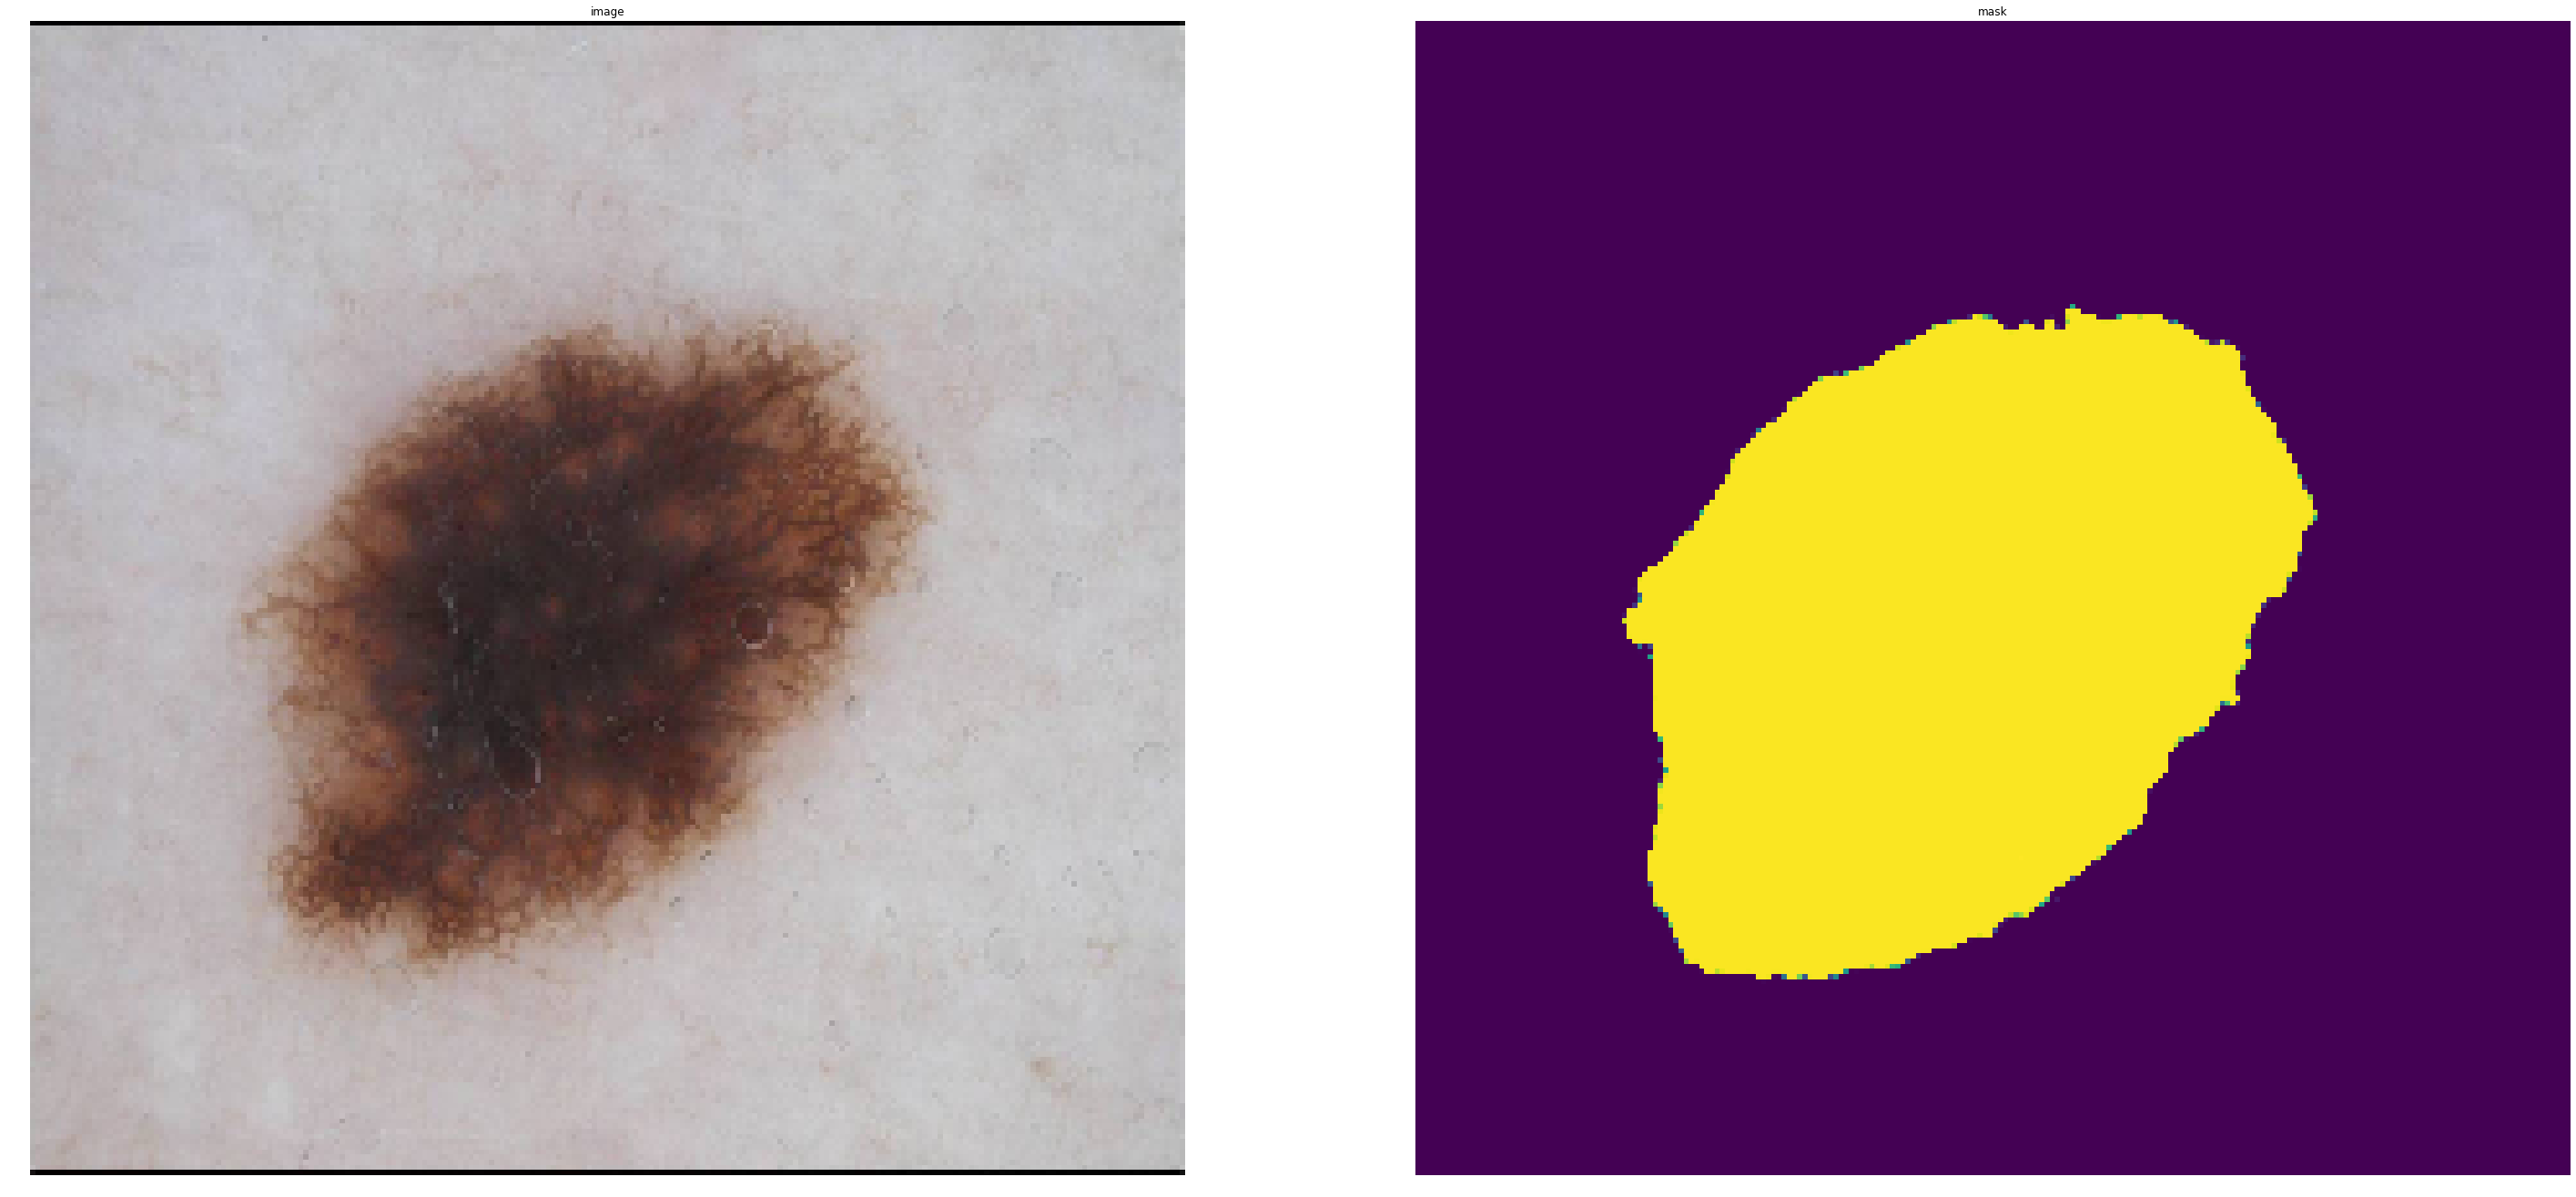

In [27]:
file_names = next(os.walk(test_data_dir))[2]

showPredictResult(file_names[3], model, 224, 224)

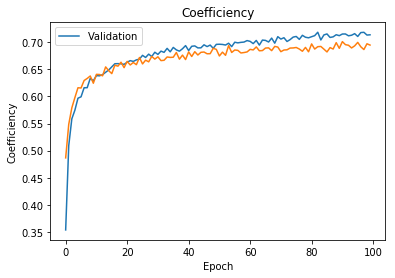

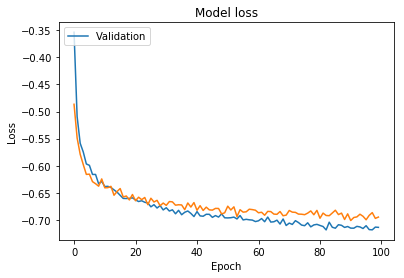

Training co-effiency    : 0.7184177907064433;
Validation co-effiency : 0.6917850740590886


In [6]:
# Plot Training curve
plotTrainigGraph(history.history)

data/test/images/ISIC_0000006.jpg -- jaccard index: 0.8364076018333435
(224, 224, 1)


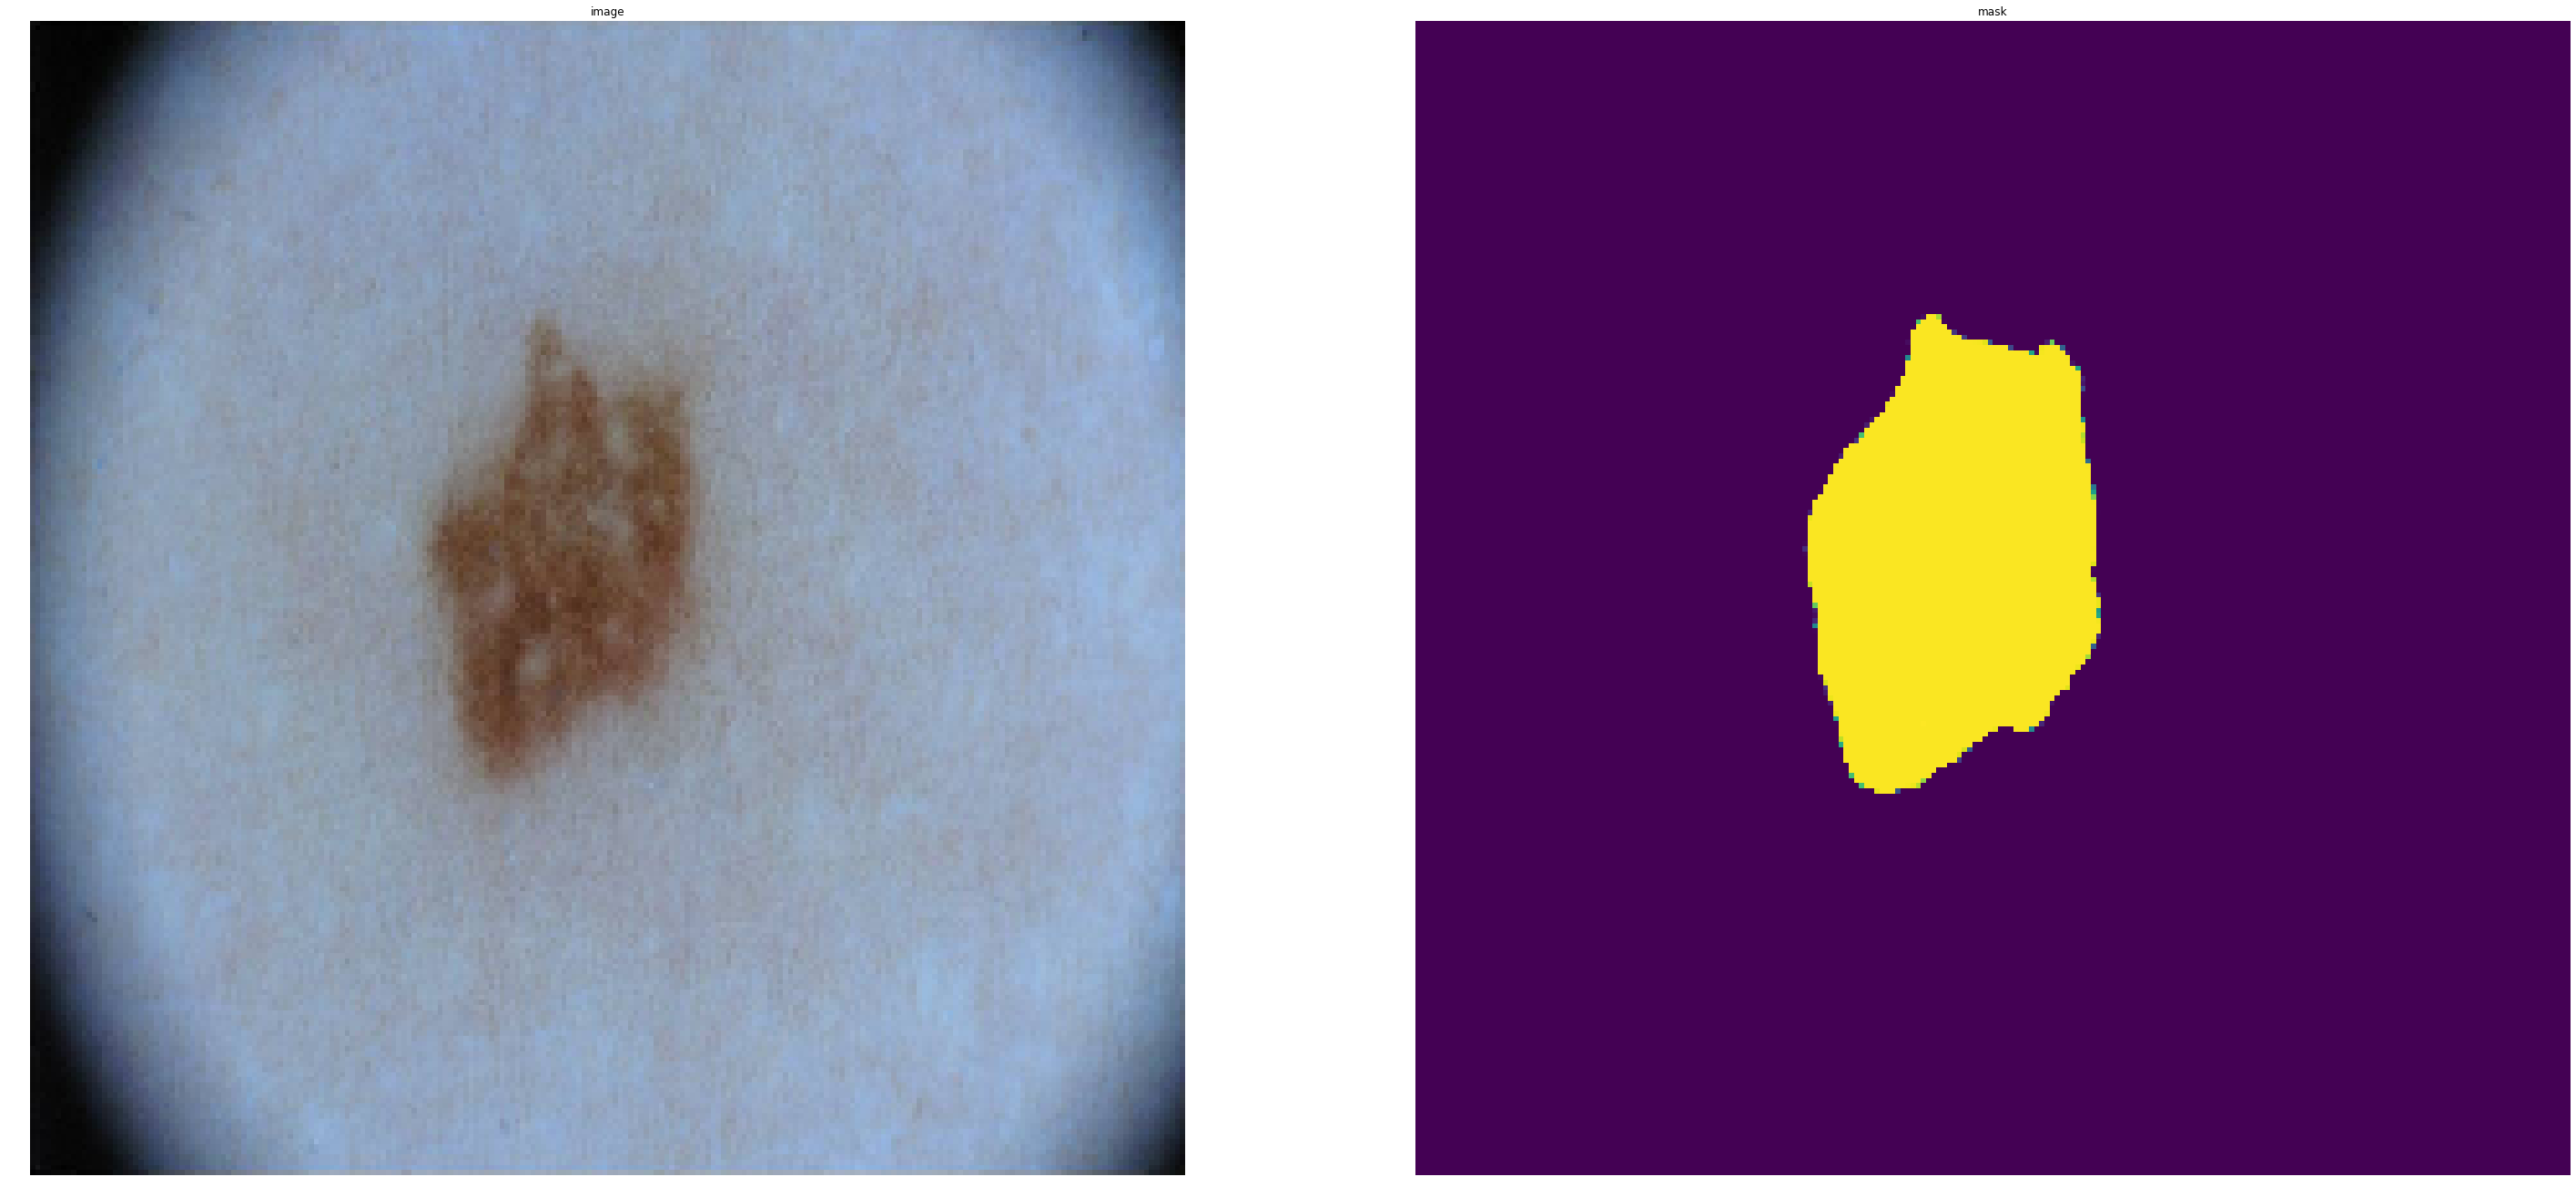

In [18]:
file = 'data/test/images/ISIC_0000006.jpg'
#grey_img = load_img(os.path.join(test_data_dir,file), target_size=(img_rows, img_cols), grayscale=False)
#mask_img = load_img(os.path.join(test_data_mask_dir,file.split('.')[0]+"_segmentation.png"), target_size=(224, 224), grayscale=True)
grey_img = load_img(file, target_size=(224, 224), grayscale=False)
mask_img = load_img('data/test/masks/ISIC_0000006_segmentation.png', target_size=(224, 224), grayscale=True)

img = img_to_array(grey_img)
img_mask = img_to_array(mask_img)

img, img_mask = normalizeData(img, img_mask)
img = np.reshape(img,(1,)+img.shape)

pred = model.predict([img])
sess = tf.Session()
score = sess.run(jaccard_coef(img_mask, pred))
print("{} -- jaccard index: {}".format(file,score))

result_img = array_to_img(pred[0] * 255 )
print(pred[0].shape)
f, ax = plt.subplots(1,2, figsize = (50,50))
ax[0].imshow(grey_img) 
ax[0].axis('off')
ax[0].set_title('image')
ax[1].imshow(result_img)
ax[1].axis('off')
ax[1].set_title('mask')
plt.show()
    

In [19]:
coef = np.array(hist['jaccard_coef'])
val_coef = np.array(hist['val_jaccard_coef'])
print("Training co-effiency    : {};\nValidation co-effiency : {}".format(coef[coef==max(coef)][0], val_coef[np.argmax(coef)]))



Training co-effiency    : 0.9701533100399135;
Validation co-effiency : 0.818605121356159


In [30]:
def predictTestSet(model, img_rows, img_cols):
    file_names = next(os.walk(test_data_dir))[2]
    scores = []
    for file in file_names:
        grey_img = load_img(os.path.join(test_data_dir,file), target_size=(img_rows, img_cols), grayscale=False)
        mask_img = load_img(os.path.join(test_data_mask_dir,file.split('.')[0]+"_segmentation.png"), 
                            target_size=(img_rows, img_cols), grayscale=True)
        img = img_to_array(grey_img)
        img_mask = img_to_array(mask_img)

        img, img_mask = normalizeData(img, img_mask)
        img = np.reshape(img,(1,)+img.shape)

        pred = model.predict([img])
        sess = tf.Session()
        score = sess.run(jaccard_coef(img_mask, pred))
        print("{} -- jaccard index: {}".format(file,score))
        scores.append([file,score])

        result_img = array_to_img(pred[0] * 255 )
        result_img.save(os.path.join(test_data_pred_dir, file.split('.')[0] + '_predict.jpg'))

    with open("unet_test_result.csv", 'w') as f:
        f.write("filename, jaccard_index\n")
        for i in range(len(scores)):
        #print(scores[i])
            f.write("{},{}\n".format(scores[i][0], scores[i][1]))

In [33]:
# Generate Jaccard Index using test set
model.load_weights('unet/20190526/unet_lesion_20190526_180-0.83202.hdf5')
predictValidationSet(model,224,224)

ISIC_0000006.jpg -- jaccard index: 0.805846631526947
ISIC_0000012.jpg -- jaccard index: 0.9086361527442932
ISIC_0000020.jpg -- jaccard index: 0.9457604885101318
ISIC_0000028.jpg -- jaccard index: 0.9664589762687683
ISIC_0000029.jpg -- jaccard index: 0.9081190228462219
ISIC_0000032.jpg -- jaccard index: 0.7644633054733276
ISIC_0000034.jpg -- jaccard index: 0.9640210866928101
ISIC_0000036.jpg -- jaccard index: 0.9463136196136475
ISIC_0000046.jpg -- jaccard index: 0.8761652708053589
ISIC_0000047.jpg -- jaccard index: 0.8867477774620056
ISIC_0000048.jpg -- jaccard index: 0.9185196161270142
ISIC_0000049.jpg -- jaccard index: 0.844952404499054
ISIC_0000060.jpg -- jaccard index: 0.9158393144607544
ISIC_0000066.jpg -- jaccard index: 0.9135443568229675
ISIC_0000075.jpg -- jaccard index: 0.954032301902771
ISIC_0000081.jpg -- jaccard index: 0.5965604186058044
ISIC_0000085.jpg -- jaccard index: 0.9234873652458191
ISIC_0000087.jpg -- jaccard index: 0.9424974322319031
ISIC_0000089.jpg -- jaccard ind

ISIC_0009940.jpg -- jaccard index: 0.8622549176216125
ISIC_0009941.jpg -- jaccard index: 0.9483429193496704
ISIC_0009951.jpg -- jaccard index: 0.6679301857948303
ISIC_0009953.jpg -- jaccard index: 0.9266226291656494
ISIC_0009965.jpg -- jaccard index: 0.7994064688682556
ISIC_0009967.jpg -- jaccard index: 0.9572415351867676
ISIC_0009987.jpg -- jaccard index: 0.7912228107452393
ISIC_0010010.jpg -- jaccard index: 0.8071995973587036
ISIC_0010015.jpg -- jaccard index: 0.9254847168922424
ISIC_0010017.jpg -- jaccard index: 0.830697774887085
ISIC_0010023.jpg -- jaccard index: 0.9357683658599854
ISIC_0010024.jpg -- jaccard index: 0.3079332113265991
ISIC_0010025.jpg -- jaccard index: 0.9165507555007935
ISIC_0010028.jpg -- jaccard index: 0.9552361369132996
ISIC_0010056.jpg -- jaccard index: 0.7626507878303528
ISIC_0010067.jpg -- jaccard index: 0.8198883533477783
ISIC_0010069.jpg -- jaccard index: 0.9351775050163269
ISIC_0010070.jpg -- jaccard index: 0.7284807562828064
ISIC_0010171.jpg -- jaccard i

ISIC_0013001.jpg -- jaccard index: 0.29213815927505493
ISIC_0013027.jpg -- jaccard index: 0.8771647214889526
ISIC_0013034.jpg -- jaccard index: 0.8302165865898132
ISIC_0013044.jpg -- jaccard index: 0.8964290618896484
ISIC_0013052.jpg -- jaccard index: 0.8934206962585449
ISIC_0013065.jpg -- jaccard index: 0.48606085777282715
ISIC_0013109.jpg -- jaccard index: 0.8983878493309021
ISIC_0013112.jpg -- jaccard index: 0.8573510646820068
ISIC_0013114.jpg -- jaccard index: 0.8677620887756348
ISIC_0013160.jpg -- jaccard index: 0.8582004308700562
ISIC_0013167.jpg -- jaccard index: 0.8968705534934998
ISIC_0013178.jpg -- jaccard index: 0.701619565486908
ISIC_0013189.jpg -- jaccard index: 0.46727025508880615
ISIC_0013203.jpg -- jaccard index: 0.7139061689376831
ISIC_0013216.jpg -- jaccard index: 0.8082611560821533
ISIC_0013224.jpg -- jaccard index: 0.7455062866210938
ISIC_0013227.jpg -- jaccard index: 0.65064936876297
ISIC_0013230.jpg -- jaccard index: 0.9448527693748474
ISIC_0013235.jpg -- jaccard 

ISIC_0015044.jpg -- jaccard index: 0.8442737460136414
ISIC_0015057.jpg -- jaccard index: 0.8100244998931885
ISIC_0015108.jpg -- jaccard index: 0.8895128965377808
ISIC_0015125.jpg -- jaccard index: 0.9254015684127808
ISIC_0015152.jpg -- jaccard index: 0.6910988092422485
ISIC_0015153.jpg -- jaccard index: 0.8630827069282532
ISIC_0015160.jpg -- jaccard index: 0.9270668625831604
ISIC_0015174.jpg -- jaccard index: 0.8674670457839966
ISIC_0015190.jpg -- jaccard index: 0.8429864048957825
ISIC_0015193.jpg -- jaccard index: 0.9394819736480713
ISIC_0015207.jpg -- jaccard index: 0.7111222147941589
ISIC_0015208.jpg -- jaccard index: 0.9564371109008789
ISIC_0015211.jpg -- jaccard index: 0.654089093208313
ISIC_0015212.jpg -- jaccard index: 0.9490787386894226
ISIC_0015215.jpg -- jaccard index: 0.8766003847122192
ISIC_0015223.jpg -- jaccard index: 0.9108254313468933
ISIC_0015229.jpg -- jaccard index: 0.878642201423645
ISIC_0015241.jpg -- jaccard index: 0.7558485865592957
ISIC_0015279.jpg -- jaccard in

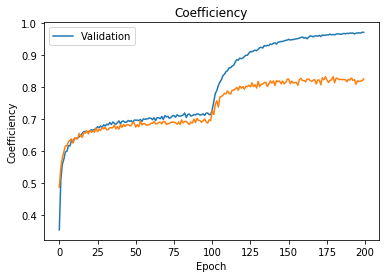

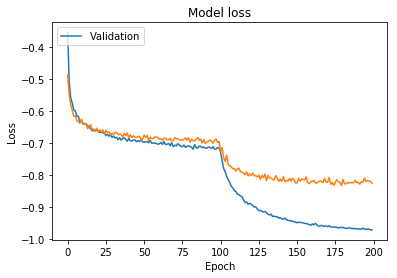

Training co-effiency    : 0.9701533100399135;
Validation co-effiency : 0.818605121356159


In [10]:
#This code combined 2 seperate training history together and plot the result
hist = {}
for i in history.history.keys():
    hist_concate = np.array([np.array(history.history[i]), np.array(history2.history[i])]).flatten() 
    hist[i] = hist_concate

plotTrainigGraph(hist)